## Photovoltiac-Module segmentation
A full pipeline for segementation, rectification and regression on photovoltaic-module pictures

In [1]:
# if the notebook runs on google colab, change the directory to google drive
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/My Drive/code/
    %cd photovoltaic_images
    root_folder = "/data"
else:
    print('Not running on CoLab')
    root_folder = "data"

Not running on CoLab


In [5]:
# install some modules
if 'google.colab' in str(get_ipython()):
    !pip install pycocotools
    !pip install git+https://github.com/tensorflow/examples.git
    !pip install pydot
    !pip install pydotplus
    !pip install graphviz
    !pip install imantics
    !pip install autokeras

In [6]:
from pycocotools.coco import COCO
import numpy as np

import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pydot
from imantics import Polygons, Mask
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import cv2

## For visualizing results

import matplotlib.gridspec as gridspec
import sys
%matplotlib inline

Using TensorFlow backend.


In [7]:
from utils import *
from models.model import *
import rectification as rec

In [8]:
# Main Parameter
# Segmentation
model_name = 'mobile_net_v2'
EPOCHS = 1000

# Regression
nr_images_batch = 5000
nr_batch = 3
nr_epoch = 2

In [9]:
# Parameter
x = 192
y = 192

batch_size = 1
input_image_size = (x,y)
OUTPUT_CHANNELS = 1

folder = 'data/Rathausen_192x192'
mode_train = 'train'

mode_val = 'val'
mode_test = 'test'

folder_deepsolareye = 'data/SolarPanelSoilingImageDataset/Solar_Panel_Soiling_Image_dataset/PanelImages'

STEPS_PER_EPOCH = 250
#VAL_SUBSPLITS = 5
VALIDATION_STEPS = 4

In [10]:
# select the model
model = eval(model_name + '([192,192,3])')

In [11]:
# start logging
log = RuntimeLogger("logs/", model_name, EPOCHS)
log.start()

In [12]:
# initial the images folder objects
images_train, dataset_size_train, coco = filterDataset(folder,  mode_train)
coco_train = coco

images_val, dataset_size_val, coco = filterDataset(folder,  mode_val)
coco_val = coco

images_test, dataset_size_test, coco = filterDataset(folder,  mode_test)
coco_test = coco

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
# initialize the folder object for deepsolareye
images_deepsolareye, dataset_size_deepsolareye, coco = filterDatasetDeepSolarEye(folder_deepsolareye, 45000)
coco_deepsolar = coco

In [14]:
# initialze the tensorflow generators
gen_train = dataGeneratorCoco(images_train, coco_train, folder,
                            input_image_size, batch_size, mode_train)
gen_val = dataGeneratorCoco(images_val, coco_val, folder,
                            input_image_size, batch_size, mode_val)
gen_test = dataGeneratorCoco(images_test, coco_test, folder,
                            input_image_size, batch_size, mode_test)

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=2), 
                       tf.keras.metrics.Recall(), 
                       tf.keras.metrics.Precision()])

In [16]:
def show_predictions(model, dataset=None, num=4):
    """[summary]

    Args:
        dataset ([type], optional): [description]. Defaults to None.
        num (int, optional): [description]. Defaults to 4.
    """
    if dataset:
        for i in range(0, num):
            image, mask = next(dataset)
            pred_mask = model.predict(image)
            display([image[0], mask[0], pred_mask[0]])
    else:
        img = model.predict(sample_image)
        display([sample_image[0], sample_mask[0],
             img[0]])

In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
    """[summary]

    Args:
        tf ([type]): [description]
    """
    def on_epoch_end(self, epoch, logs=True):
        """[summary]

        Args:
            epoch ([type]): [description]
            logs (bool, optional): [description]. Defaults to True.
        """
        clear_output(wait=False)
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))  

In [18]:
img, mask = next(gen_val)
sample_image = img
sample_mask = mask

In [19]:
img = model.predict(sample_image)

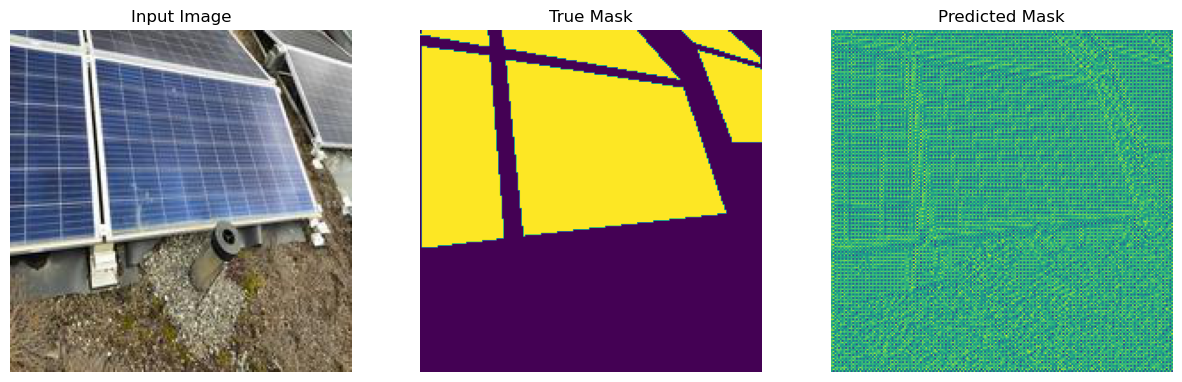

In [20]:
show_predictions(model)

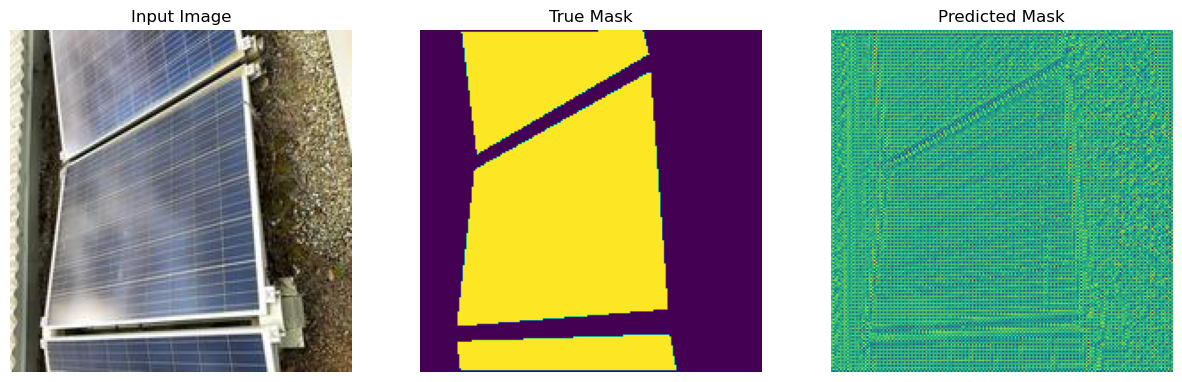

In [21]:
show_predictions(model, gen_train, 1)

In [ ]:
# train the model
training_start_time = time()
model_history = model.fit(gen_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=gen_val,
                          #callbacks=[DisplayCallback()]
                         )
training_time = time() - training_start_time
log.log_task_end('segmentation_time', training_start_time)
print("--- %s seconds ---" % (training_time))

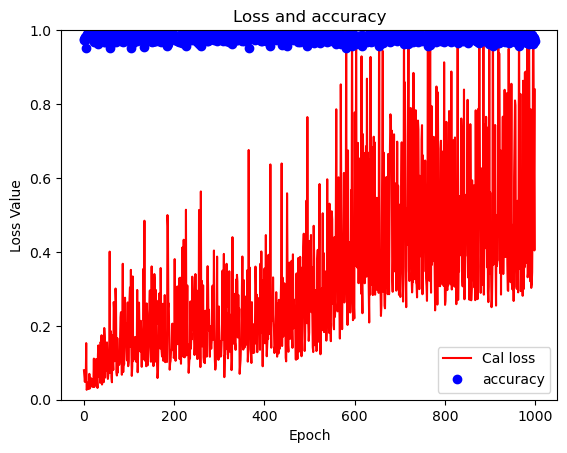

In [23]:
loss = model_history.history['val_loss']
accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Cal loss')
plt.plot(epochs, accuracy, 'bo', label='accuracy')
plt.title('Loss and accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [1]:
show_predictions(model, gen_train, 1)

NameError: name 'show_predictions' is not defined

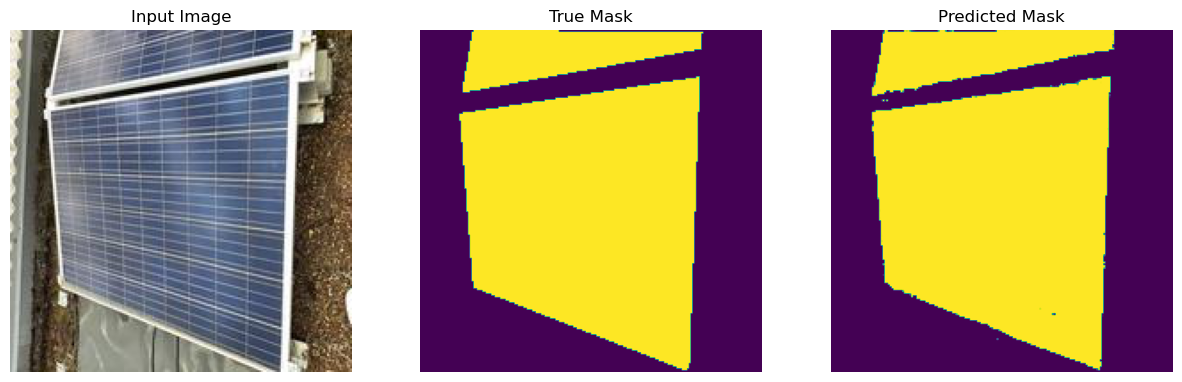

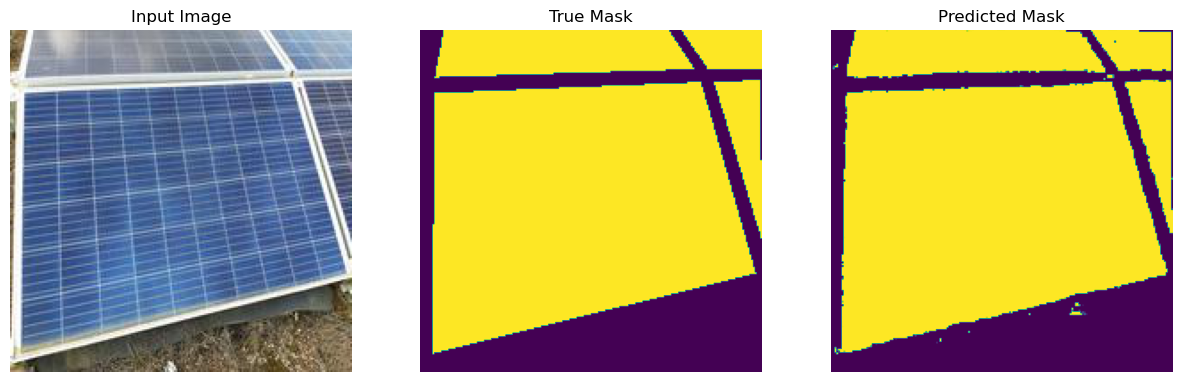

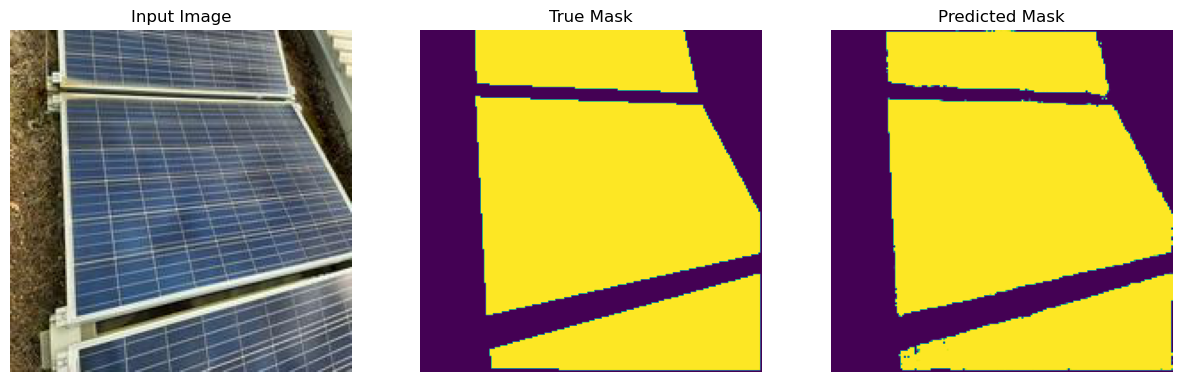

In [25]:
show_predictions(model, gen_val, 3)

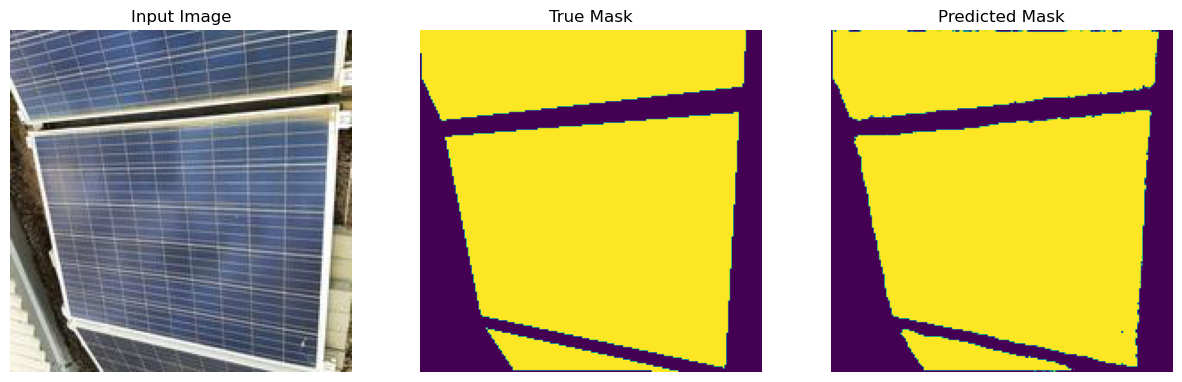

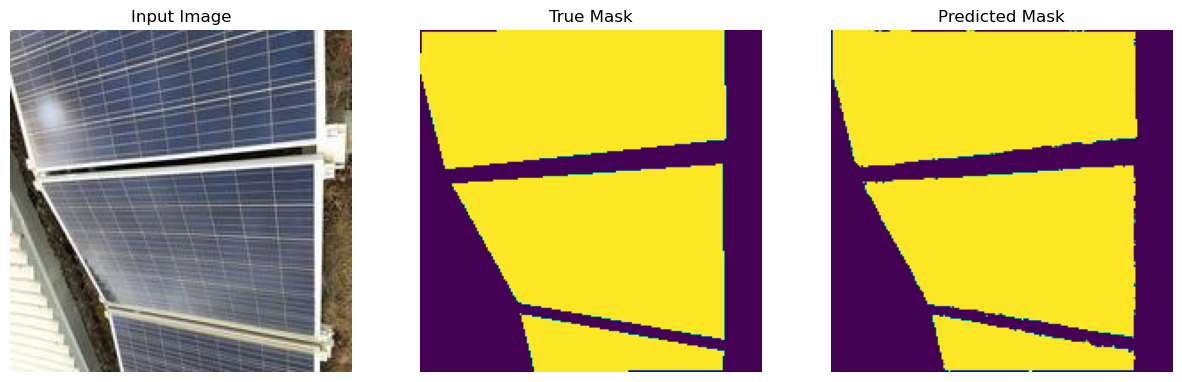

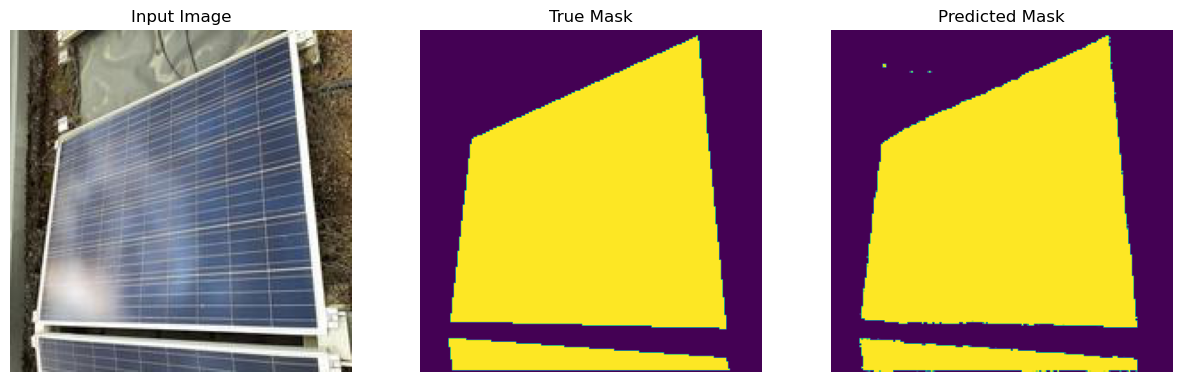

In [26]:
show_predictions(model, gen_test, 3)

## Evaluate Bildsegmentierung

In [27]:
val_dice, val_jaccard = calc_predictions(model, gen_val, 50)

Dice 0.98067254
Jaccard 1.963000338766318


In [28]:
test_dice, test_jaccard = calc_predictions(model, gen_test, 33)

Dice 0.9848434
Jaccard 1.7503969721647037


In [29]:
test_loss, test_accuracy, test_mean_io_u, test_recall, test_precision = model.evaluate(gen_test, batch_size=batch_size, steps=33)

33/33 [==============================] - 0s 10ms/step - loss: 0.5580 - accuracy: 0.9800 - mean_io_u: 0.9559 - recall: 0.9855 - precision: 0.9830


In [30]:
# Print Model Summary:
print("MODEL SUMMARY")
print("-------------")
print("Training Accuracy:", model_history.history['accuracy'][-1:][0])
print("Validation Accuracy:", model_history.history['val_accuracy'][-1:][0])
print("Test Accuracy:", test_accuracy)
print("-------------")
print("Training Loss:", model_history.history['loss'][-1:][0])
print("Validation Loss:", model_history.history['val_loss'][-1:][0])
print("Training mean_io_u:", model_history.history['mean_io_u'][-1:][0])
print("Validation mean_io_u:", model_history.history['mean_io_u'][-1:][0])
print("-------------")
print("Validation Dice:", np.mean(val_dice))
print("Validation Jaccard:", np.mean(val_jaccard))
print("Test Dice:", np.mean(test_dice))
print("Test Jaccard:", np.mean(test_jaccard))



MODEL SUMMARY
-------------
Training Accuracy: 1.0
Validation Accuracy: 0.9717610478401184
Test Accuracy: 0.9800289869308472
-------------
Training Loss: 1.2091372347811102e-09
Validation Loss: 0.8392260074615479
Training mean_io_u: 0.9963330030441284
Validation mean_io_u: 0.9963330030441284
-------------
Validation Dice: 0.98067254
Validation Jaccard: 1.963000338766318
Test Dice: 0.9848434
Test Jaccard: 1.7503969721647037


In [31]:
# add Metric to the log
log.add_metric('Training Accuracy', model_history.history['accuracy'][-1:][0])
log.add_metric('Validation Accuracy', model_history.history['val_accuracy'][-1:][0])
log.add_metric('Test Accuracy', test_accuracy)
log.add_metric('Training Loss', model_history.history['loss'][-1:][0])
log.add_metric('Validation Loss', model_history.history['val_loss'][-1:][0])
log.add_metric('Test Loss', test_loss)
log.add_metric('Training  mean_io_u', model_history.history['mean_io_u'][-1:][0])
log.add_metric('Validation mean_io_u', model_history.history['val_mean_io_u'][-1:][0])
log.add_metric('Test mean_io_u', test_mean_io_u)
log.add_metric('Training Recall', model_history.history['recall'][-1:][0])
log.add_metric('Validation Recall', model_history.history['val_recall'][-1:][0])
log.add_metric('Test Recall', test_recall)
log.add_metric('Training  Precision', model_history.history['precision'][-1:][0])
log.add_metric('Validation Precision', model_history.history['val_precision'][-1:][0])
log.add_metric('Test Precision', test_precision)
log.add_metric('Validation Dice', np.mean(val_dice))
log.add_metric('Validation Jaccard', np.mean(val_jaccard))
log.add_metric('Test Dice', np.mean(test_dice))
log.add_metric('Test Jaccard', np.mean(test_jaccard))




In [32]:
model.save('model/' + str(model_name) + '_' + str(EPOCHS))

In [16]:
model = keras.models.load_model('model/' + str(model_name) + '_' + str(EPOCHS))

# Store, Registration and Recification

In [17]:
predict_and_store(model, model_name + str(EPOCHS), 'Rathausen_192x192', images_test, dataset_size_test, folder, x, y, root_folder)

number of images predicted 0


In [18]:
training_start_time = time()
predict_and_store(model, model_name + str(EPOCHS), 'DeepSolarEye_192x192', images_deepsolareye, dataset_size_deepsolareye, folder_deepsolareye, x, y, root_folder)
training_time = time() - training_start_time
log.log_task_end('predict_deepsolareye_time', training_start_time)
print("--- %s seconds ---" % (training_time))

number of images predicted 0
number of images predicted 250
number of images predicted 500
recification for image not possible
recification for image not possible
recification for image not possible
number of images predicted 750
--- 203.2787265777588 seconds ---


# Regression

In [15]:
# Make Regression on recification deep solar eye pictures
#folder = "../data/test/DeepSolarEye_192x192_rec"
folder = "{}/{}/DeepSolarEye_192x192_rec".format(root_folder, model_name + str(EPOCHS) )
folder

'data/mobile_net_v21000/DeepSolarEye_192x192_rec'

In [16]:
training_start_time = time()
model, mse, rmse, mae = train_keras(model_name, folder, nr_images_batch, nr_batch, nr_epoch, 25)
training_time = time() - training_start_time
log.log_task_end('regression_time', training_start_time)
print("--- %s seconds ---" % (training_time))

--- Batch 0 --- 
select from to 0 5000
Files in train_files: 5000
1000 images to array
2000 images to array
3000 images to array
4000 images to array
5000 images to array
All images to array!
Epoch 1/2
200/200 [==============================] - 20s 77ms/step - loss: 0.2056 - mean_squared_error: 0.2056
Epoch 2/2
200/200 [==============================] - 16s 78ms/step - loss: 6.5611 - mean_squared_error: 6.5611
--- Batch 1 --- 
select from to 5000 10000
Files in train_files: 5000
1000 images to array
2000 images to array
3000 images to array
4000 images to array
5000 images to array
All images to array!
Epoch 1/2
200/200 [==============================] - 16s 77ms/step - loss: 0.1937 - mean_squared_error: 0.1937
Epoch 2/2
200/200 [==============================] - 15s 77ms/step - loss: 3.3771 - mean_squared_error: 3.3771
--- Batch 2 --- 
select from to 10000 15000
Files in train_files: 5000
1000 images to array
2000 images to array
3000 images to array
4000 images to array
5000 images t

## Evaluate Regression

In [17]:
# Print Model Summary:
print("MODEL SUMMARY")
print("-------------")
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)

MODEL SUMMARY
-------------
Test MSE: 7.189092
Test RMSE: 2.6812482
Test MAE: 0.037919067


In [18]:
# add Metric to the log
log.add_metric('Regression MSE', mse)
log.add_metric('Regression RMSE', rmse)
log.add_metric('Regression MAE', mae)

# End of Experiment

In [19]:
log.log_experiment_end()

In [20]:
model.save('models/regression' + str(model_name) + '_' + str(EPOCHS))

AttributeError: 'ImageRegressor' object has no attribute 'save'